<a href="https://colab.research.google.com/github/amsewr/planeclassification/blob/main/notebooks/train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data & imports

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar zxf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  28.5M      0  0:01:32  0:01:32 --:--:-- 28.5M


In [2]:
%%writefile requirements.txt

pathlib==1.0.1
matplotlib==3.5.0
numpy==1.21.5
pandas==1.3.5
tensorflow==2.8.0
keras==2.8.0

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

In [26]:
import pathlib 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yaml

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from sklearn.model_selection import train_test_split
from PIL import Image
from yaml.loader import SafeLoader

# Constantes

In [2]:
%%writefile launch.yaml

---
DATA_DIR: dataset/data
MODEL_DIR: model/planes
TARGET_NAME : manufacturer



IMAGE_WIDTH: 128
IMAGE_HEIGHT: 128
IMAGE_DEPTH: 3

Writing launch.yaml


In [3]:
with open('launch.yaml') as f:
  data = yaml.load(f, Loader=SafeLoader)
  print(data)

{'DATA_DIR': 'dataset/data', 'MODEL_DIR': 'model/planes', 'TARGET_NAME': 'manufacturer', 'IMAGE_WIDTH': 128, 'IMAGE_HEIGHT': 128, 'IMAGE_DEPTH': 3}


In [4]:
DATA_DIR = pathlib.Path(data['DATA_DIR'])
MODEL_DIR = pathlib.Path(data['MODEL_DIR'])
TARGET_NAME = data['TARGET_NAME']
IMAGE_WIDTH = data['IMAGE_WIDTH']
IMAGE_HEIGHT = data['IMAGE_HEIGHT']
IMAGE_DEPTH = data['IMAGE_DEPTH']

# Functions

In [7]:
def build_image_database(path, target) :
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path) : path pattern to read csv file containing images information. 
  target (str) : name of the target column.

  Returns 
  -------
  A pandas dataframe, including target class and path to image.
  """

  _df =pd.read_csv(path, sep='\t'
                , names=['all']
                , dtype ={'all':str} # id are string not int
                )

  #split donne une chaine de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  #'<car>'.join(liste) concatène les éléments de la liste avec le séparateur '<car>'
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x +'.jpg'))

  return _df.drop(columns=['all'])

# Load manufacturer_df

In [12]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', TARGET_NAME)

In [10]:
# La fonction :
# - prend un df (argument) 
# - prend une ligne (row : argument, l'indice de la ligne)
# - prend une colonne (target : argument)
# - elle affiche la classe (valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target) : 
  """Show an image from an image database, with the associated class

  Parameters
  -----------
  df(pd.DataFrame) : images definition dataframe
  row (int) :  row index in df of image to be displayed
  target (str) : name of the target column

  Returns
  ---------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))

  return

CRJ-700


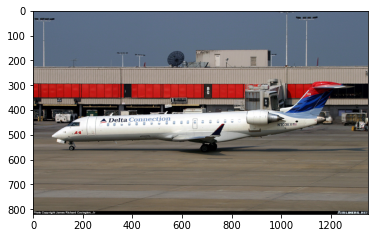

In [ ]:
show_image(build_image_database(DATA_DIR / 'images_family_train.txt', 'family'), 1515, 'family')

de Havilland


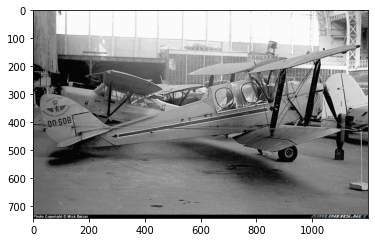

In [13]:
show_image(manufacturer_df, 1930, TARGET_NAME)

# Verify data

In [ ]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing                      733
Airbus                      434
Embraer                     233
McDonnell Douglas           232
de Havilland                167
Canadair                    134
Douglas Aircraft Company    133
Cessna                      133
British Aerospace           133
Fokker                      100
Lockheed Corporation         68
Beechcraft                   67
Saab                         67
Gulfstream Aerospace         67
Dassault Aviation            67
Tupolev                      66
ATR                          66
Panavia                      34
Yakovlev                     34
Lockheed Martin              34
Dornier                      34
Antonov                      34
Bombardier Aerospace         33
Ilyushin                     33
Fairchild                    33
Piper                        33
Cirrus Aircraft              33
Supermarine                  33
Robin                        33
Eurofighter                  33
Name: manufacturer, dtype: int64

In [ ]:
assert manufacturer_df['image_id'].isna().sum() == 0, "Missing values in image_id"
assert manufacturer_df['manufacturer'].isna().sum() == 0, "Missing values in manufcaturer"

# Tenserflow

In [ ]:
manufacturer_df.shape

(3334, 3)

In [ ]:
manufacturer_df.head()

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014,Boeing,dataset/data/images/0450014.jpg


Boeing


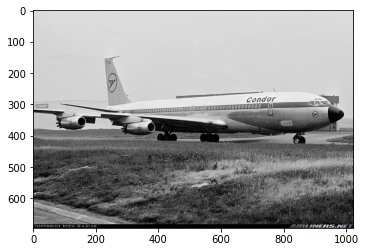

In [14]:
show_image(manufacturer_df, 0, TARGET_NAME)

In [ ]:
manufacturer_df['shape'] = manufacturer_df['path'].apply(lambda p: plt.imread(p).shape)

In [ ]:
# Distribution du nombre de colonnes
manufacturer_df['shape'].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: shape, Length: 73, dtype: int64

In [15]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size.

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width
  
  Returns
  -------
  np.array containing resized image
  """
  return np.array(Image.open(path).resize((width, height)))

In [16]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

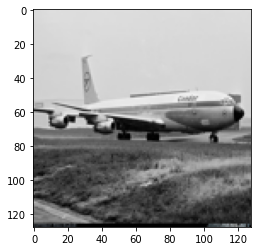

In [ ]:
plt.imshow(manufacturer_df.iloc[0,]['resized_image'])

In [ ]:
# Calcul du nombre de classes pour dimensionner la couche de sortie
nb_classes = manufacturer_df[TARGET_NAME].nunique()
nb_classes

30

In [17]:
def build_classification_model(df, target, images):
  """Build a TF model using information from target and images columns in dataframe. 

  Parameters
  ----------
  df (pd.DataFrame) : dataframe with target and images columns
  target (str) : column name for target variable
  images (str) : column name for images

  Returns
  -------
  TF model built a compiled
  """
  nb_classes = df[target].nunique() # compute number of classes for output layer
  size = df[images].iloc[0].shape # compute images size for input layer

  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape= size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax'))

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# Build train & test set

In [18]:
def build_x_and_y(df : pd.DataFrame, target : str, images : str):
  """Build x tensor and y tensor for model fitting. 

  Parameters
  -----------
  df (pd.DataFrame) : dataframe containing images and target 
  target (str) : name of target column
  images (str) : name of images column

  Returns
  ---------
  x (np.array) : tensor for x values 
  y (np.array) : tensor for y valuess
  """

  x = np.array(df[images].to_list())
  y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  return x, y


In [19]:
# Load train & test dataset
train_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', TARGET_NAME)
test_df = build_image_database(DATA_DIR / 'images_manufacturer_test.txt', TARGET_NAME)

# Load & resize images
train_df['resized_images'] = train_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)
test_df['resized_images'] = test_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df, TARGET_NAME, 'resized_images')
X_test, y_test = build_x_and_y(test_df, TARGET_NAME, 'resized_images')

# Build TF classification model
model = build_classification_model(train_df, TARGET_NAME, 'resized_images')

In [ ]:
# A faire une fois pour récupérer les informations sur la TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [21]:
with tpu_strategy.scope():
  model = build_classification_model(train_df, TARGET_NAME, 'resized_images')

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

!rm -rf ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs,
                    validation_data=(X_test, y_test))

In [ ]:
train_df[TARGET_NAME].astype('category').cat.categories

Index(['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing',
       'Bombardier Aerospace', 'British Aerospace', 'Canadair', 'Cessna',
       'Cirrus Aircraft', 'Dassault Aviation', 'Dornier',
       'Douglas Aircraft Company', 'Embraer', 'Eurofighter', 'Fairchild',
       'Fokker', 'Gulfstream Aerospace', 'Ilyushin', 'Lockheed Corporation',
       'Lockheed Martin', 'McDonnell Douglas', 'Panavia', 'Piper', 'Robin',
       'Saab', 'Supermarine', 'Tupolev', 'Yakovlev', 'de Havilland'],
      dtype='object')

In [24]:
def classify_images(images, model,classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names : dictionary with names of classes

  Returns
  --------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # np.argmax is computed row by row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

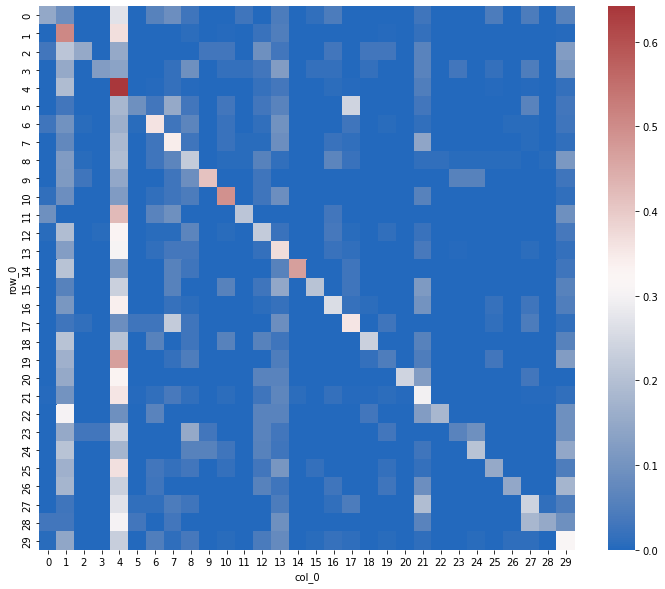

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_test, axis=1), classify_images(X_test, model), normalize='index'), cmap='vlag',ax=ax)

<AxesSubplot:xlabel='col_0', ylabel='manufacturer'>

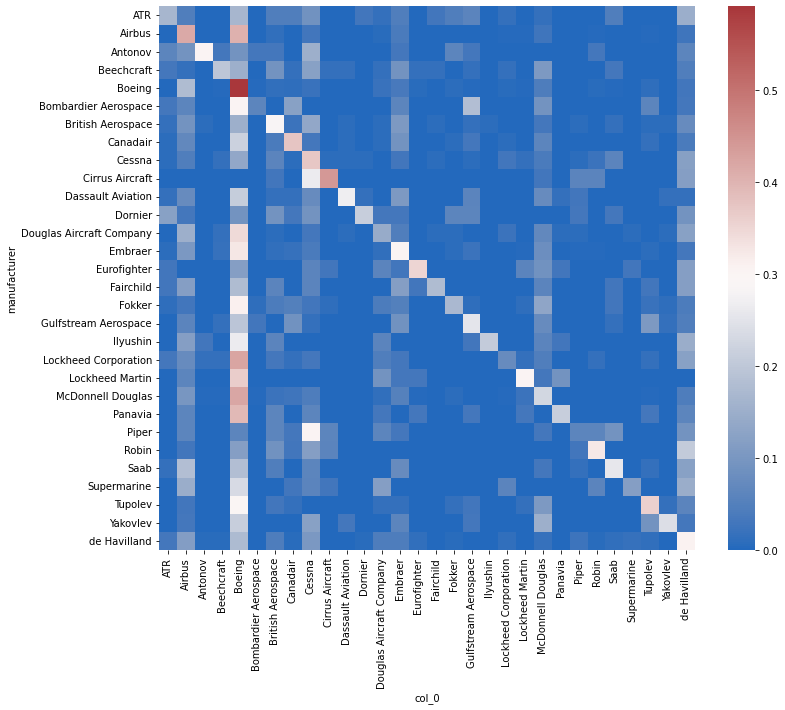

In [27]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME], classify_images(X_test, model,test_df[TARGET_NAME].astype('category').cat.categories), 
                        normalize='index'), cmap='vlag',ax=ax)

In [28]:
import datetime

def save_model(model, basename):
  """Save tf/Keras model.

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}_{}.h5'.format(basename, TARGET_NAME))
  return

In [29]:
save_model(model,MODEL_DIR)